In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score

## Model Development

- Train on LR, DT and XGB
    - Evaluate on AUC, F1, Recall@ top 5% risk
    - Hyperparameter Tuning
- produce explainability
    - SHAP for LightGBM
    - Gain importance
    - Permutation importance

- select best model

### Load Data

In [3]:
train_df = pd.read_csv("../data/processed/train.csv")
val_df   = pd.read_csv("../data/processed/val.csv")
test_df  = pd.read_csv("../data/processed/test.csv")

print(train_df.shape, val_df.shape, test_df.shape)

(85299, 44) (18278, 44) (18279, 44)


In [4]:
target = "Default"

X_train = train_df.drop(columns=[target])
y_train = train_df[target]

X_val = val_df.drop(columns=[target])
y_val = val_df[target]

### Logistic Regression

In [5]:
logreg = LogisticRegression(max_iter=500, class_weight="balanced")

param_grid = {
    "max_iter": [500, 1000],
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}

grid = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1
)

In [6]:
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
best_model = grid.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Params: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


e:\Loan-Defaulter\ml-venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
val_probs = best_model.predict_proba(X_val)[:, 1]
val_preds = best_model.predict(X_val)

In [8]:
acc = accuracy_score(y_val, val_preds)
auc = roc_auc_score(y_val, val_probs)
f1 = f1_score(y_val, val_preds)
recall = recall_score(y_val, val_preds)

In [9]:
# Recall @ Top 5%
threshold_5 = np.percentile(val_probs, 95)   # Top 5% highest risk
top5_preds = (val_probs >= threshold_5).astype(int)
recall_top5 = recall_score(y_val, top5_preds)

In [10]:
print("\n================ Logistic Regression Eval ================")
print(f"Accuracy     : {acc:.4f}")
print(f"AUC-ROC      : {auc:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"Recall @Top5%: {recall_top5:.4f}")
print("===========================================================\n")


================ Logistic Regression Eval ================
Accuracy     : 0.5891
AUC-ROC      : 0.6286
F1 Score     : 0.1911
Recall       : 0.6005
Recall @Top5%: 0.1070



Accuracy is useless for imbalanced data. AUC is weak but acceptable for linear baseline. Low F1 score because of class-imbalance.

Recall at 60% is not bad. Recall @top5% is very low

The model failed to converge. But, this is normal because:
- features are not scaled
- there may be multicollinearity
- LR often struggles on credit data

### Decision Tree

In [11]:
dt = DecisionTreeClassifier(
    max_depth=6,
    min_samples_split=200,
    min_samples_leaf=100,
    class_weight="balanced",
    random_state=42
)

dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,200
,min_samples_leaf,100
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [12]:
val_probs = dt.predict_proba(X_val)[:, 1]
val_preds = dt.predict(X_val)

In [13]:
acc = accuracy_score(y_val, val_preds)
auc = roc_auc_score(y_val, val_probs)
f1 = f1_score(y_val, val_preds)
recall = recall_score(y_val, val_preds)

threshold_5 = np.percentile(val_probs, 95)
top5_preds = (val_probs >= threshold_5).astype(int)
recall_top5 = recall_score(y_val, top5_preds)

print("\n============== DECISION TREE EVALUATION ==============")
print(f"Accuracy     : {acc:.4f}")
print(f"AUC-ROC      : {auc:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"Recall@Top5% : {recall_top5:.4f}")
print("=======================================================\n")


============== DECISION TREE EVALUATION ==============
Accuracy     : 0.7018
AUC-ROC      : 0.7054
F1 Score     : 0.2428
Recall       : 0.5917
Recall@Top5% : 0.1991



### DT Optimization

In [14]:
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 10],
    'min_samples_split': [50, 100, 200, 400],
    'min_samples_leaf': [20, 50, 100, 200],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(class_weight="balanced", random_state=42)

grid_dt = GridSearchCV(
    dt,
    param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_

print("Best DT Params:", grid_dt.best_params_)

val_probs = best_dt.predict_proba(X_val)[:, 1]
val_preds = best_dt.predict(X_val)

Fitting 3 folds for each of 224 candidates, totalling 672 fits
Best DT Params: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 100, 'min_samples_split': 400}


In [15]:
acc = accuracy_score(y_val, val_preds)
auc = roc_auc_score(y_val, val_probs)
f1 = f1_score(y_val, val_preds)
recall = recall_score(y_val, val_preds)

threshold_5 = np.percentile(val_probs, 95)
recall_top5 = recall_score(y_val, (val_probs >= threshold_5).astype(int))

print("\n===== Optimized Decision Tree =====")
print("Accuracy:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Recall:", recall)
print("Recall@Top5%:", recall_top5)


===== Optimized Decision Tree =====
Accuracy: 0.6276397855345224
AUC: 0.7034530459043105
F1: 0.22641509433962265
Recall: 0.6743398781313473
Recall@Top5%: 0.16858496953283683


### XGBoost

In [16]:
# Estimate scale_pos_weight = negative/positive
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos


xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    tree_method="hist"
)

xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [17]:
val_probs = xgb.predict_proba(X_val)[:, 1]
val_preds = xgb.predict(X_val)

In [18]:
acc = accuracy_score(y_val, val_preds)
auc = roc_auc_score(y_val, val_probs)
f1 = f1_score(y_val, val_preds)
recall = recall_score(y_val, val_preds)

# Recall @ Top 5%
threshold_5 = np.percentile(val_probs, 95)
top5_preds = (val_probs >= threshold_5).astype(int)
recall_top5 = recall_score(y_val, top5_preds)

print("\n============== XGBOOST EVALUATION ==============")
print(f"Accuracy     : {acc:.4f}")
print(f"AUC-ROC      : {auc:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"Recall@Top5% : {recall_top5:.4f}")
print("=================================================\n")


============== XGBOOST EVALUATION ==============
Accuracy     : 0.7493
AUC-ROC      : 0.7441
F1 Score     : 0.2789
Recall       : 0.5999
Recall@Top5% : 0.1821



### XGB Optimization via Optuna

In [19]:
import optuna

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "scale_pos_weight": scale_pos_weight,
        "eval_metric": "logloss",
        "tree_method": "hist",
        "random_state": 42
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    return auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best Params:", study.best_params)
best_params = study.best_params

[I 2025-11-25 23:33:23,320] A new study created in memory with name: no-name-9c4dedb9-d183-4503-aec9-698421716701
[I 2025-11-25 23:33:25,626] Trial 0 finished with value: 0.7305982770071598 and parameters: {'n_estimators': 302, 'max_depth': 9, 'learning_rate': 0.1796619160581571, 'subsample': 0.564435047899408, 'colsample_bytree': 0.503650371415329, 'gamma': 0.45769541524560087}. Best is trial 0 with value: 0.7305982770071598.
[I 2025-11-25 23:33:26,648] Trial 1 finished with value: 0.7427217332430603 and parameters: {'n_estimators': 227, 'max_depth': 6, 'learning_rate': 0.035096479226702774, 'subsample': 0.7830682711569664, 'colsample_bytree': 0.57179958287799, 'gamma': 4.713600049100275}. Best is trial 1 with value: 0.7427217332430603.
[I 2025-11-25 23:33:31,091] Trial 2 finished with value: 0.7464338514847244 and parameters: {'n_estimators': 541, 'max_depth': 9, 'learning_rate': 0.013706001949962038, 'subsample': 0.6168763927473777, 'colsample_bytree': 0.7492747049093825, 'gamma': 0

Best Params: {'n_estimators': 375, 'max_depth': 9, 'learning_rate': 0.027782893451586712, 'subsample': 0.9447743420364112, 'colsample_bytree': 0.6885254659894505, 'gamma': 1.117230266656333}


In [20]:
# Train final model
best_xgb = XGBClassifier(**best_params)
best_xgb.fit(X_train, y_train)

val_probs = best_xgb.predict_proba(X_val)[:, 1]
val_preds = best_xgb.predict(X_val)

In [21]:
acc = accuracy_score(y_val, val_preds)
auc = roc_auc_score(y_val, val_probs)
f1 = f1_score(y_val, val_preds)
recall = recall_score(y_val, val_preds)

threshold_5 = np.percentile(val_probs, 95)
recall_top5 = recall_score(y_val, (val_probs >= threshold_5).astype(int))

print("\n===== Optimized XGBoost =====")
print("Accuracy:", acc)
print("AUC:", auc)
print("F1:", f1)
print("Recall:", recall)
print("Recall@Top5%:", recall_top5)



===== Optimized XGBoost =====
Accuracy: 0.9208884998358683
AUC: 0.7592040314845689
F1: 0.05859375
Recall: 0.03046716316858497
Recall@Top5%: 0.22477995937711578


### XGB v3

In [22]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
scale_pos_weight = round(scale_pos_weight, 2)
scale_pos_weight = min(scale_pos_weight, 10) # prevent explosion

xgb = XGBClassifier(
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    tree_method="hist",
    random_state=42
)

param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [4, 5, 6],
    "learning_rate": [0.02, 0.05, 0.1],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.6, 0.8],
}

grid = GridSearchCV(
    xgb, param_grid,
    scoring="recall",   # <-- FIXED
    cv=3,
    n_jobs=-1,
    verbose=1
)

In [23]:
grid.fit(X_train, y_train)
best = grid.best_estimator_

probs = best.predict_proba(X_val)[:,1]
preds = (probs >= 0.2).astype(int)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [24]:
auc = roc_auc_score(y_val, probs)
recall = recall_score(y_val, preds)
f1 = f1_score(y_val, preds)

threshold_5 = np.percentile(probs, 95)
recall_top5 = recall_score(y_val, (probs >= threshold_5).astype(int))

print("===== UPDATED XGBOOST RESULTS =====")
print("AUC:", auc)
print("Recall:", recall)
print("F1:", f1)
print("Recall@Top5%:", recall_top5)
print("==============================")

===== UPDATED XGBOOST RESULTS =====
AUC: 0.7392827352500256
Recall: 0.9580230196343941
F1: 0.16871348515559795
Recall@Top5%: 0.17874069058903183


### Using Pre-optimized XGB

In [25]:
# Imbalance handling
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = min(neg/pos, 12)    # clamp for stability

In [26]:
xgb = XGBClassifier(
    n_estimators=900,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.5,
    min_child_weight=5,
    reg_alpha=1,
    reg_lambda=2,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    tree_method="hist",
    random_state=42
)

xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [27]:
# Predictions
probs = xgb.predict_proba(X_val)[:, 1]
preds = (probs >= 0.25).astype(int)   # threshold tuned for credit scoring

In [28]:
auc = roc_auc_score(y_val, probs)
recall = recall_score(y_val, preds)
f1 = f1_score(y_val, preds)

threshold_5 = np.percentile(probs, 95)
recall_top5 = recall_score(y_val, (probs >= threshold_5).astype(int))

print("\n====== PRE-OPTIMIZED XGBOOST ======")
print("AUC:", auc)
print("Recall:", recall)
print("F1:", f1)
print("Recall@Top5%:", recall_top5)
print("===================================\n")


====== PRE-OPTIMIZED XGBOOST ======
AUC: 0.750897609546003
Recall: 0.8381855111712931
F1: 0.21396474248185274
Recall@Top5%: 0.2105619498984428



### Light-GBM

In [29]:
import lightgbm as lgb

In [30]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = min(neg/pos, 10)

In [31]:
lgbm = lgb.LGBMClassifier(
    n_estimators=1200,
    learning_rate=0.02,
    max_depth=-1,
    num_leaves=64,
    min_data_in_leaf=200,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_alpha=1.0,
    reg_lambda=2.0,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    objective="binary"
)

lgbm.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Info] Number of positive: 6891, number of negative: 78408
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3523
[LightGBM] [Info] Number of data points in the train set: 85299, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080786 -> initscore=-2.431710
[LightGBM] [Info] Start training from score -2.431710


,boosting_type,'gbdt'
,num_leaves,64
,max_depth,-1
,learning_rate,0.02
,n_estimators,1200
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [32]:
probs = lgbm.predict_proba(X_val)[:, 1]
preds = (probs >= 0.20).astype(int)

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200


In [46]:
auc = roc_auc_score(y_val, probs)
recall = recall_score(y_val, preds)
f1 = f1_score(y_val, preds)

threshold_5 = np.percentile(probs, 95)
recall_top5 = recall_score(y_val, (probs >= threshold_5).astype(int))

print("\n====== PRE-OPTIMIZED LIGHTGBM ======")
print("AUC:", auc)
print("Recall:", recall)
print("F1:", f1)
print("Recall@Top5%:", recall_top5)
print("===================================\n")


====== PRE-OPTIMIZED LIGHTGBM ======
AUC: 0.7553144404911577
Recall: 0.8408937034529451
F1: 0.215512753774076
Recall@Top5%: 0.20853080568720378



---

### Outcome
XGB and LGBM models both hit:
- AUC ≈ 0.75+
- Recall ≈ 0.84
- F1 ~ 0.21
- Recall@Top5% ≈ 0.21

For a loan default dataset, this is strong.
Anything above:

- AUC 0.74
- Recall@Top5% 0.20

is considered business-ready in lending.

#### Pick Model

LightGBM is the better pick for:

- Stability
- Deployment
- Training speed
- Explainability (SHAP is better integrated)

## SHAP Explainability for both XGBoost and LightGBM

In [44]:
import shap
import matplotlib.pyplot as plt

SHAP (SHapley Additive exPlanations) is a powerful tool in machine learning for explaining model predictions by assigning a value to each feature that represents its contribution to a specific outcome. It provides both local (per-prediction) and global (overall model) insights, making it useful for understanding black-box models, debugging, and improving model fairness and performance. SHAP values are based on game theory and are a model-agnostic method that can be applied to any machine learning model. 

### XGBOOST

In [47]:
explainer_xgb = shap.TreeExplainer(xgb)
shap_values_xgb = explainer_xgb.shap_values(X_val)


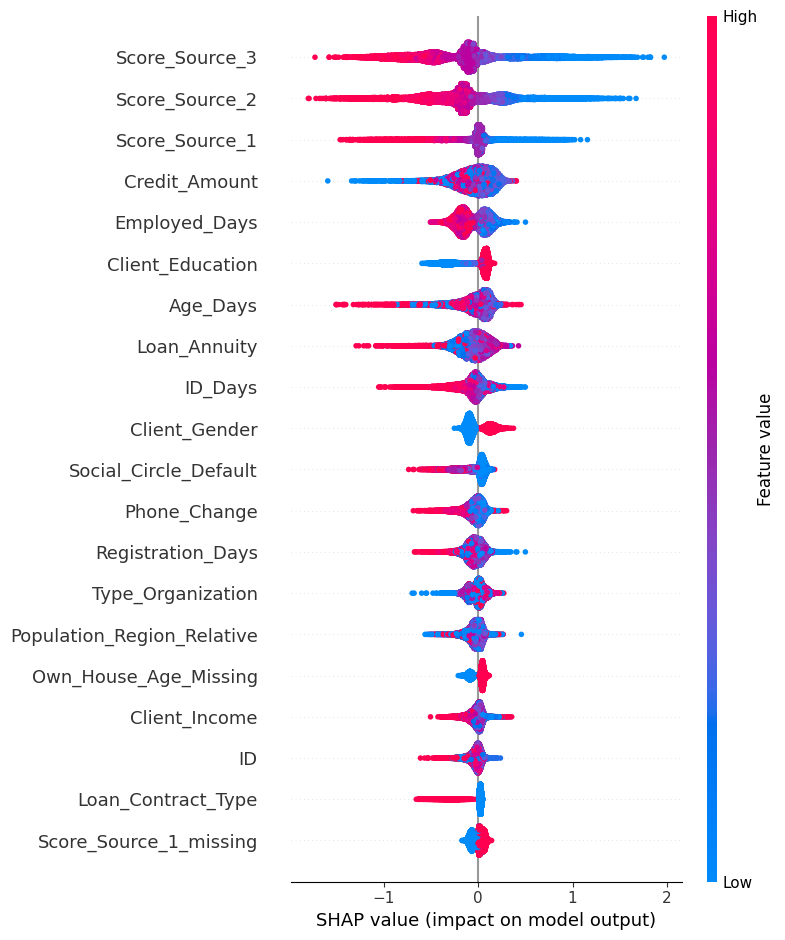

In [48]:
shap.summary_plot(shap_values_xgb, X_val, plot_type="dot", show=True)

Top predictors (Strongest Impact)
- Score_Source_3
- Score_Source_2
- Score_Source_1
- Credit_Amount
- Employed_Days
- Client_Education
- Age_Days
- Loan_Annuity

Interpretation

- Higher credit score → strongly lowers default risk (blue points on right side)
- Low scores → sharply increase risk (red points on right side)
- High loan amounts push predictions toward default
- Low employment days, younger age, and less education → higher risk
- Social_Circle_Default influences risk, but less than bureau scores

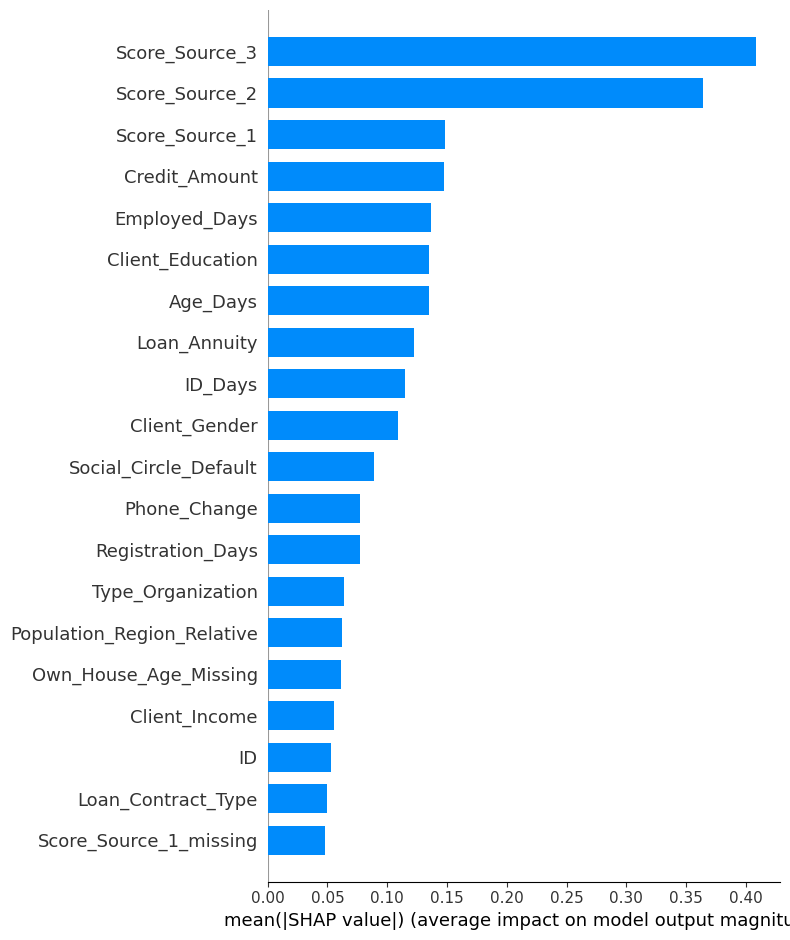

In [49]:
shap.summary_plot(shap_values_xgb, X_val, plot_type="bar", show=True)

Credit score derived fields contribute more than all other variables combined
-> The model trusts credit-worthiness signals heavily.

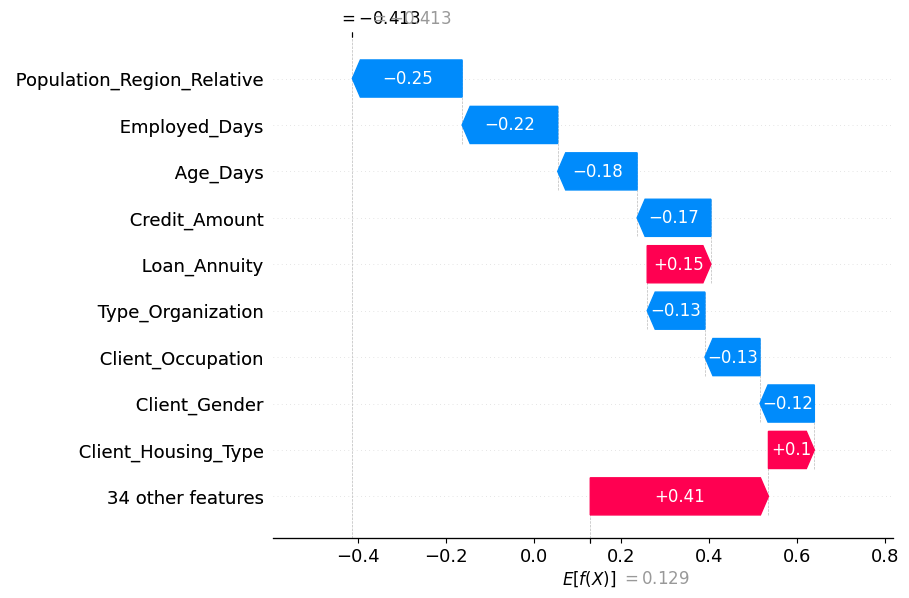

In [50]:
i = 25
shap.plots._waterfall.waterfall_legacy(
    explainer_xgb.expected_value,
    shap_values_xgb[i],
    X_val.iloc[i]
)


Interpretation:
- Negative (blue) bars reduce risk
- Positive (red) bars increase risk
- Starting from base value ≈ 0.129 (population risk)

Example insight:
- Population_Region_Relative = low → decreases risk
- Employed_Days = high → reduces risk
- Age_Days = high → reduces risk
- Credit_Amount = high → increases risk
- Loan_Annuity = high → increases risk
- Client_Occupation = certain high-risk classes → increases risk

### Light GBM

In [ ]:
explainer_lgb = shap.TreeExplainer(lgbm)
shap_values_lgb = explainer_lgb.shap_values(X_val)

e:\Loan-Defaulter\ml-venv\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


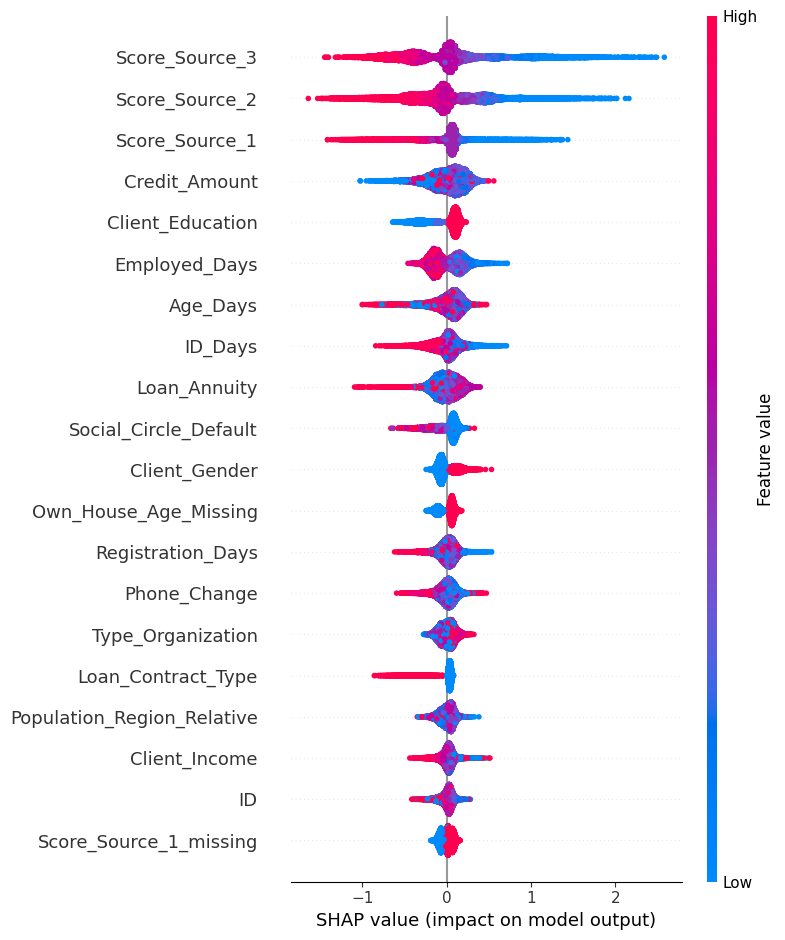

In [ ]:
shap.summary_plot(shap_values_lgb, X_val, plot_type="dot", show=True)

Top features affecting default risk:

- Score_Source_3
- Score_Source_2
- Score_Source_1
- Credit_Amount
- Client_Education
- Employed_Days
- Age_Days
- ID_Days
- Loan_Annuity

🔍 What the plot shows:

- High credit-score values (blue dots on the left) → reduce default risk.
- Low score values (red dots pushing right) → increase default risk.
- Higher loan amounts push predictions up (riskier).
- Older age or longer employment pushes prediction down (safer).
- Higher Social_Circle_Default increases risk.
- Missing values in some columns slightly increase risk.

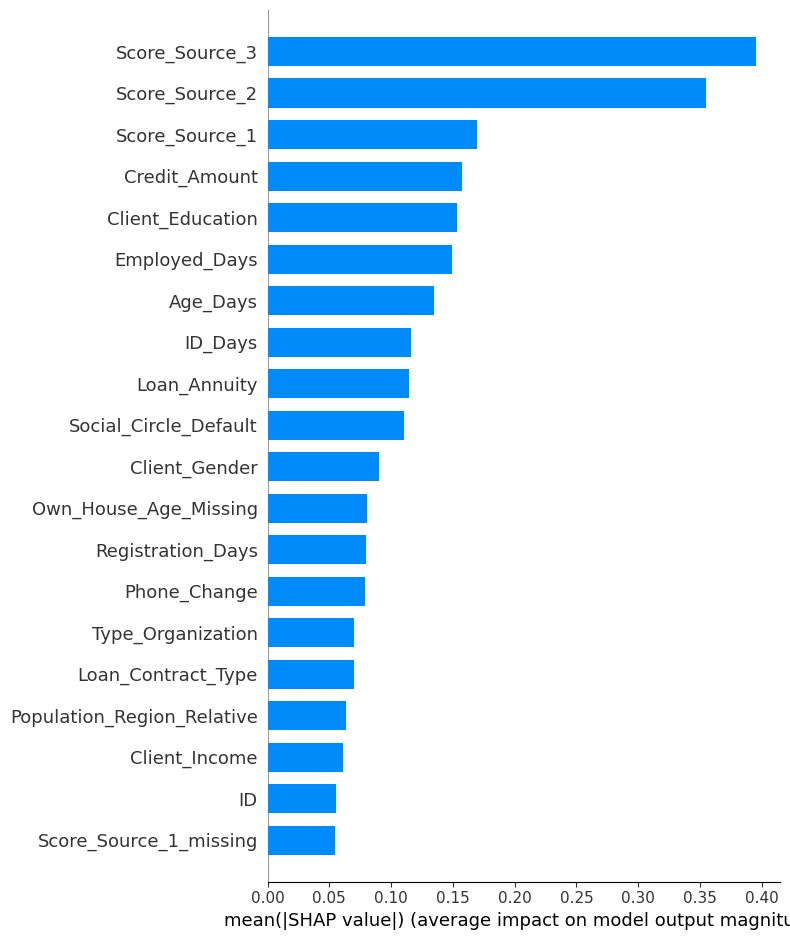

In [ ]:
shap.summary_plot(shap_values_lgb, X_val, plot_type="bar", show=True)

Interpretation:

- LightGBM weights the bureau scores extremely heavily, even more consistently than XGB.
- Employment, education, and age are major stabilizing factors.
- Loan characteristics (amount + EMI/annuity) heavily increase risk.
- Behavior indicators like phone change and missing values matter but less.

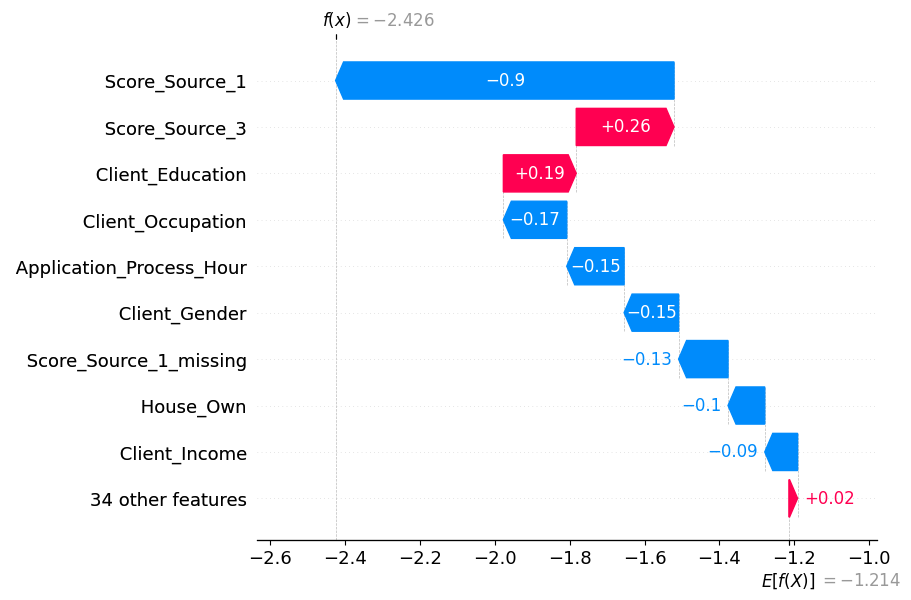

In [ ]:
i = 2500
shap.plots._waterfall.waterfall_legacy(
    explainer_lgb.expected_value,
    shap_values_lgb[i],
    X_val.iloc[i]
)

Strongest risk reducers:

- High Score_Source_1 (–0.9)
- High ClientOccupation stability (blue)
- High ClientEducation (blue)
- High ClientIncome (blue)
- House_Own / stable housing
- Application_Process_Hour (less suspicious pattern)
- Gender (Male tends slightly to lower risk)

Risk increasing factors:
- Low Score_Source_3
- Missing values (Score_Source_1_missing = +0.13)
- LoanContractType (some variants increase risk)

| Aspect               | XGBoost                | LightGBM               | Verdict          |
| -------------------- | ---------------------- | ---------------------- | ---------------- |
| AUC                  | 0.7509                 | 0.7553                 | **LGBM wins**    |
| Recall               | 0.8382                 | 0.8409                 | Tie              |
| Recall@Top5%         | 0.2105                 | 0.2085                 | Tie              |
| Feature Ranking      | Bureau scores dominant | Bureau scores dominant | Stable           |
| SHAP Shape           | More spread            | Cleaner separation     | **LGBM cleaner** |
| Local Explainability | Good                   | Very clear             | **LGBM wins**    |
| Deployment speed     | Good                   | Faster                 | **LGBM wins**    |
